In [1]:
import os
from pathlib import Path
import pickle
from datasets import load_dataset

curr_dir = Path(os.getcwd())
data_dir = curr_dir / 'data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
data_pickle_path = data_dir / 'data_set.pkl'

if not os.path.exists(data_pickle_path):
    print(f"Data set hasn't been loaded. Loading from the datasets library and save it as a pickle.")
    data_set = load_dataset("vipulmaheshwari/GTA-Image-Captioning-Dataset")
    with open(data_pickle_path, 'wb') as outfile:
        pickle.dump(data_set, outfile)
else:
    print(f"Data set already exists in the local drive. Loading it.")
    with open(data_pickle_path, 'rb') as infile:
        data_set = pickle.load(infile)

Data set already exists in the local drive. Loading it.


In [2]:
print(data_set)
len(data_set['train']['image']), len(data_set['train']['text'])

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 785
    })
})


(785, 785)

Description: there is a man walking down a hill with a skateboard


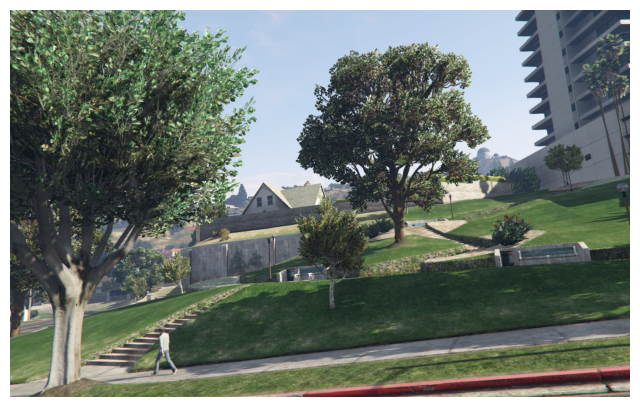

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.axis("off")

image = data_set['train']['image'][0]
text = data_set['train']['text'][0]

plt.imshow(image)
print(f"Description: {text}")

Description: there is a street with a yellow line on it and a red car


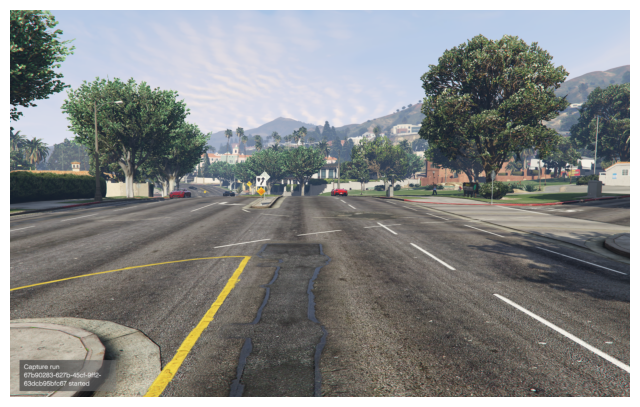

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.axis("off")

image = data_set['train']['image'][1]
text = data_set['train']['text'][1]

plt.imshow(image)
print(f"Description: {text}")

In [5]:
# # Source: https://huggingface.co/sentence-transformers/clip-ViT-L-14

# from sentence_transformers import SentenceTransformer, util
# from PIL import Image

# #Load CLIP model
# model = SentenceTransformer("sentence-transformers/clip-ViT-L-14") # SentenceTransformer('clip-ViT-L-14')

# #Encode an image:
# img_emb = model.encode(image) # Image.open('two_dogs_in_snow.jpg')

# #Encode text descriptions
# text_emb = model.encode(text) # ['Two dogs in the snow', 'A cat on a table', 'A picture of London at night']

# #Compute cosine similarities 
# cos_scores = util.cos_sim(img_emb, text_emb)
# print(cos_scores)

In [ ]:
# https://huggingface.co/openai/clip-vit-large-patch14

In [3]:
import clip
import torch
import os
from datasets import load_dataset

# ds = load_dataset("vipulmaheshwari/GTA-Image-Captioning-Dataset")
# device = torch.device("mps")
model, preprocess = clip.load("ViT-L/14") # , device=device

In [2]:
import pyarrow as pa
import lancedb
import tqdm

db = lancedb.connect('./data/tables')
schema = pa.schema(
  [
      pa.field("vector", pa.list_(pa.float32(), 512)),
      pa.field("text", pa.string()),
      pa.field("id", pa.int32())
  ])
tbl = db.create_table("gta_data", schema=schema, mode="overwrite")

In [3]:
tbl

LanceTable(connection=LanceDBConnection(d:\OneDrive\GitHub\Apziva\GrandTheftAuto-multimodal-RAG-application\data\tables), name="gta_data")

In [ ]:
# https://vipul-maheshwari.github.io/2024/03/03/multimodal-rag-application

def embed_image(img):
    processed_image = preprocess(img)
    unsqueezed_image = processed_image.unsqueeze(0).to(device)
    embeddings = model.encode_image(unsqueezed_image)
    
    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

In [ ]:
data = []
for i in range(len(ds["train"])):
    img = ds["train"][i]['image']
    text = ds["train"][i]['text']
    
    # Encode the image
    encoded_img = embed_image(img)
    data.append({"vector": encoded_img, "text": text, "id" : i})

In [ ]:
tbl.add(data)
tbl.to_pandas()

In [ ]:
def embed_txt(txt):
    tokenized_text = clip.tokenize([txt]).to(device)
    embeddings = model.encode_text(tokenized_text)
    
    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

res = tbl.search(embed_txt("a road with a stop")).limit(3).to_pandas()
res

In [ ]:
https://blog.lancedb.com/lancedb-polars-2d5eb32a8aa3/

https://github.com/lancedb/lancedb